# Кейс от Вконтакте: механизм ранжирования комментариев

Комментарии низкого качества ухудшают общее восприятие поста и сайта в целом. Именно поэтому важно ранжировать комментарии пользователей, а впоследствии и модерировать их, чтобы вначале показывать только те, которые действительно дополняют ценность контента.

**Задача:** разработать  механизм ранжирования комментариев на основе методов машинного обучения и в будущем создать более интересное и вовлекающее сообщество комментаторов.

Задача состоит из двух более мелких: представления текста и затем ранжирования.

*Условия*:
1. Использовать инструменты предобработки текста;
2. После обучения проанализировать полученные результаты и сформулировать полезные инсайты о том, что обычно содержит популярный комментарий;
3. Мерика качества - NDCG, но можно использовать другие методы оценки.

# Обучение модели

На этапе предобработки и анализа данных нам удалось очистить комментарии, а также лемматизировать и токенизировать их. Используя облако слов мы проверили качество предобработки данных и убедились, что можем двигаться дальше.

Файл с данными для обучения лежит в файле clear_train.csv.

## План обучения:
1. Векторизация признаков
2. Обучение моделей
3. Анализ результатов
4. Проверка модели на адекватность и предсказания на тестовых данных

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import warnings
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive

import gensim
import gensim.downloader as api
from gensim.utils import tokenize
from gensim.utils import lemmatize
from gensim import corpora
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS 
from scipy.sparse import csr_matrix 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ndcg_score
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split, ShuffleSplit

from google.colab import drive

In [ ]:
# игнорируем предупреждения

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

## Объявление констант

In [ ]:
RS = 42
CV = ShuffleSplit(n_splits=2, test_size=0.25, random_state=RS)

## Загрузка данных


In [ ]:
# подключение гугл диска
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pth_1 = 'clear_train.csv'
pth_2 = '/content/drive/MyDrive/clear_train.csv'

if os.path.exists(pth_1):
    data_train = pd.read_csv(pth_1)
else: 
  data_train = pd.read_csv(pth_2)

In [ ]:
pth_1 = 'clear_test.csv'
pth_2 = '/content/drive/MyDrive/clear_test.csv'

if os.path.exists(pth_1):
    df_test = pd.read_csv(pth_1)
else: 
  df_test = pd.read_csv(pth_2)

In [ ]:
df_test.head()

,Unnamed: 0,text,comment_text,comment_score,comment_clear_list,comment_clear
0,0,"iOS 8.0.1 released, broken on iPhone 6 models,...",I&#x27;m still waiting for them to stabilize w...,NaN,"['waiting', 'stabilize', 'wifi', 'ipad', 'sith...",waiting stabilize wifi ipad sith io quality st...
1,1,"iOS 8.0.1 released, broken on iPhone 6 models,...","For those who upgraded, no need to do a restor...",NaN,"['upgraded', 'need', 'restore', 'option', 'cli...",upgraded need restore option click quot update...
2,2,"iOS 8.0.1 released, broken on iPhone 6 models,...",Upgraded shortly after it was released and suf...,NaN,"['upgraded', 'shortly', 'released', 'suffered'...",upgraded shortly released suffered consequence...
3,3,"iOS 8.0.1 released, broken on iPhone 6 models,...",I think they were under a lot of pressure on t...,NaN,"['think', 'lot', 'pressure', 'healthkit', 'big...",think lot pressure healthkit big flagship io f...
4,4,"iOS 8.0.1 released, broken on iPhone 6 models,...",Fix for those who already updated: http:&#x2F...,NaN,"['fix', 'updated', 'url']",fix updated url


In [ ]:
# Возьмём выборку из данных, на ней будем обучать алгоритм
data_train = data_train.sample(n=15000, random_state=RS)

In [ ]:
data_train.head()

,Unnamed: 0,text,comment_text,comment_score,comment_clear_list,comment_clear
215313,215313,Simple - An Obtvse clone written in Python,So much drama around what is basically a skin/...,3,"['drama', 'basically', 'skin', 'cosmetic', 'im...",drama basically skin cosmetic improvement good...
87434,87434,I am designing and developing free websites fo...,Hmm.If you're going to sell your work for free...,4,"['hmm', 'going', 'sell', 'work', 'free', 'imo'...",hmm going sell work free imo making market web...
406662,406662,HTML5 Gaming Performance Test,The main bottleneck in WebKit was Object.proto...,2,"['main', 'bottleneck', 'webkit', 'object', 'pr...",main bottleneck webkit object prototype hasown...
274636,274636,A Peep inside a C# Application Service,It seems like this article could use explanati...,1,"['like', 'article', 'use', 'explanation', 'com...",like article use explanation comment incorrect...
201259,201259,Official PHP site will have a new design,I quite like it. I don't think it's too bad as...,4,"['like', 'think', 'bad', 'standalone', 'site',...",like think bad standalone site compared previo...


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 215313 to 379154
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          15000 non-null  int64 
 1   text                15000 non-null  object
 2   comment_text        15000 non-null  object
 3   comment_score       15000 non-null  int64 
 4   comment_clear_list  15000 non-null  object
 5   comment_clear       14995 non-null  object
dtypes: int64(2), object(4)
memory usage: 820.3+ KB


<Axes: >

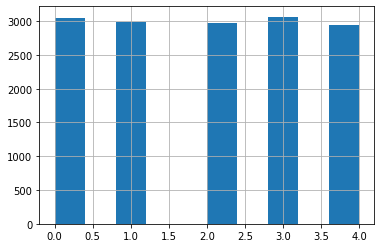

In [ ]:
# проверим распределение
data_train['comment_score'].hist()

In [ ]:
# Разбиение на обучающую, тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(data_train["comment_clear_list"], data_train["comment_score"], test_size=0.25, shuffle=True, random_state=RS)

In [ ]:
X_test_to_pred = df_test["comment_clear_list"]

## Векторизация

Перед обучением модели мы проведем векторизацию: признаки, получаемые на основе векторных представлений слов, более информативны, чем бинарные признаки, которые просто указывают на наличие или отсутствие слов в тексте.

Для векторизации слов в текстах мы будем использовать Word2Vec, тк этот метод:
- способен улавливать смысловые связи между словами и создавать векторное представление текста на основе семантики его слов
- может учитывать контекст слов
- имеет большой выбор готовых моделей, обученных на больших корпусах текстов, что упрощает работу с ним

In [ ]:
# Преобразование меток классов в формат multiclass-multioutput, чтобы потом рассчитать метрику

def nparray_to_multiclass_multioutput(np_array_name):
  multi = to_categorical(np_array_name, num_classes=5)
  return multi

In [ ]:
y_train_np = Y_train.values # np array

In [ ]:
y_test_np = Y_test.values # np array
y_test_multi = nparray_to_multiclass_multioutput(y_test_np) # multiclass-multioutput

In [ ]:
# создаём объект модели Word2Vec
w2v_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Обучим word2vec model на тренировочной выборке
w2v_trained_model = Word2Vec(X_train, size=100, min_count=1, workers=4)

In [ ]:
# сохранение модели w2v
w2v_trained_model.save('/content/drive/MyDrive/w2v_trained_model.w2v')

In [ ]:
# обработка в векторы X_train

# получаем размерность векторов из модели word2vec
w2v_vector_size = w2v_trained_model.vector_size

# преобразуем каждое предложение в вектор с помощью модели word2vec
X_train_vectors = []
for sentence in X_train:
    # создаем пустой вектор
    sentence_vector = np.zeros(w2v_vector_size)
    # суммируем векторы слов в предложении
    for word in sentence:
        try:
            sentence_vector += w2v_trained_model[word]
        except KeyError:
            print(word, 'not in vocabulary')
        sentence_vector += w2v_trained_model[word]
    # добавляем полученный вектор в список векторов
    X_train_vectors.append(sentence_vector)

# преобразуем список векторов в разреженную матрицу формата csr_matrix
X_train = csr_matrix(X_train_vectors)

In [ ]:
# получаем размерность векторов из модели word2vec
w2v_vector_size = w2v_trained_model.vector_size

# преобразуем каждое предложение в вектор с помощью модели word2vec
X_test_vectors = []
for sentence in X_test:
    # создаем пустой вектор
    sentence_vector = np.zeros(w2v_vector_size)
    # суммируем векторы слов в предложении
    for word in sentence:
        try:
            sentence_vector += w2v_trained_model[word]
        except KeyError:
            print(word, 'not in vocabulary')
    # добавляем полученный вектор в список векторов
    X_test_vectors.append(sentence_vector)

In [ ]:
vector_size = w2v_model.vector_size
vector_size

300

In [ ]:
Y_train

132761    1
254240    0
305820    0
113395    0
352437    2
         ..
166208    3
101502    2
12901     1
119404    4
244375    0
Name: comment_score, Length: 11250, dtype: int64

In [ ]:
X_test_vectors

[array([ 3.50881585e+01,  5.39145405e+01, -4.72952584e+01,  8.26581249e+00,
         8.66092899e+01,  4.16435962e+01,  1.89445050e+01, -5.27052503e+01,
         2.50247516e+01, -2.98698747e+01, -2.54561433e+01, -1.68120106e+01,
         5.62596129e+01,  8.33953742e+00,  1.14797058e+02,  1.93153093e+01,
        -8.43725835e+01, -2.68228834e+00,  7.05799077e+00, -1.68294301e+01,
         8.92254667e+00, -5.08473615e+01, -6.11477906e+01,  5.32900497e+01,
         6.48518273e+00, -6.41081741e+01,  5.54845118e+01, -3.28879036e+00,
        -5.38114616e+01,  5.75028014e+00,  4.81253005e+01, -3.35570777e+01,
        -2.81657875e+01, -6.96482347e+01, -4.02580817e+01,  8.64772967e+01,
         1.91875834e+01, -3.35841603e+01,  2.96979169e+01, -1.19646761e+02,
        -1.26528488e+02, -2.35669651e+01,  8.87627336e+01,  9.84221584e+01,
         4.74233702e+00, -2.76599427e+01, -2.66309328e+01,  1.45768567e-01,
        -4.07325139e+01, -8.53070956e+01,  8.50289734e+00, -5.59558938e+01,
        -2.7

In [ ]:
X_test = X_test_vectors.copy()

## Обучение моделей

In [ ]:
'''Функция принимает на вход объект модели и возвращает обученную модель, предсказания в nparray
и в multiclass-multioutput, метрику на валидационной выборке '''

def fit_predict(model_name):
    model_name.fit(X_train, Y_train)
    # Предсказания на тестовых данных
    y_pred = model_name.predict(X_test) # np array
    y_pred_multi = nparray_to_multiclass_multioutput(y_pred) # multiclass-multioutput

    # Считаем метрику 
    model_score = ndcg_score(y_test_multi, y_pred_multi)
    print(f'Метрика ndcg у модели:', model_score)

    fitted_model = model_name

    return fitted_model, y_pred, y_pred_multi, model_score

### LogisticRegression

In [ ]:
LR =  LogisticRegression(class_weight='balanced', random_state=RS, C=5.5843)
LR_model, y_pred_LR, y_pred_multi_LR, LR_score = fit_predict(LR)

Метрика ndcg у модели: 0.6192340124640151


In [ ]:
y_pred_LR

array([1, 0, 0, ..., 0, 0, 2])

In [ ]:
y_pred_multi_LR

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

### RandomForestClassifier

In [ ]:
random_forest = RandomForestClassifier(random_state=RS, bootstrap=False, class_weight='balanced', 
                                       n_estimators=250, min_samples_split=10, min_samples_leaf=4,
                                       max_depth=40)
RF_model, y_pred_RF, y_pred_multi_RF, RF_score = fit_predict(random_forest)

Метрика ndcg у модели: 0.6174560103670439


### LGBMClassifier

In [ ]:
LGBM_clf = LGBMClassifier(n_jobs=-1, random_state=RS, class_weight='balanced', learning_rate=0.01, 
                          boosting_type='gbdt', n_estimators=400, max_depth=5, num_leaves=40, 
                          min_child_samples=10, colsample_bytree=0.8, subsample= 0.7, 
                          reg_lambda=10, reg_alpha=1)
LGBM_model, y_pred_LGBM, y_pred_multi_LGBM, LGBM_score = fit_predict(LGBM_clf)

Метрика ndcg у модели: 0.6214223227372104


## Анализ полученных моделей

In [ ]:
models = {'LogisticRegression': LR_score, 
          'LGBMClassifier': LGBM_score,
          'RandomForestClassifier': RF_score}

df_models = pd.DataFrame(
    data=models, 
    index=['ndcg_score'])

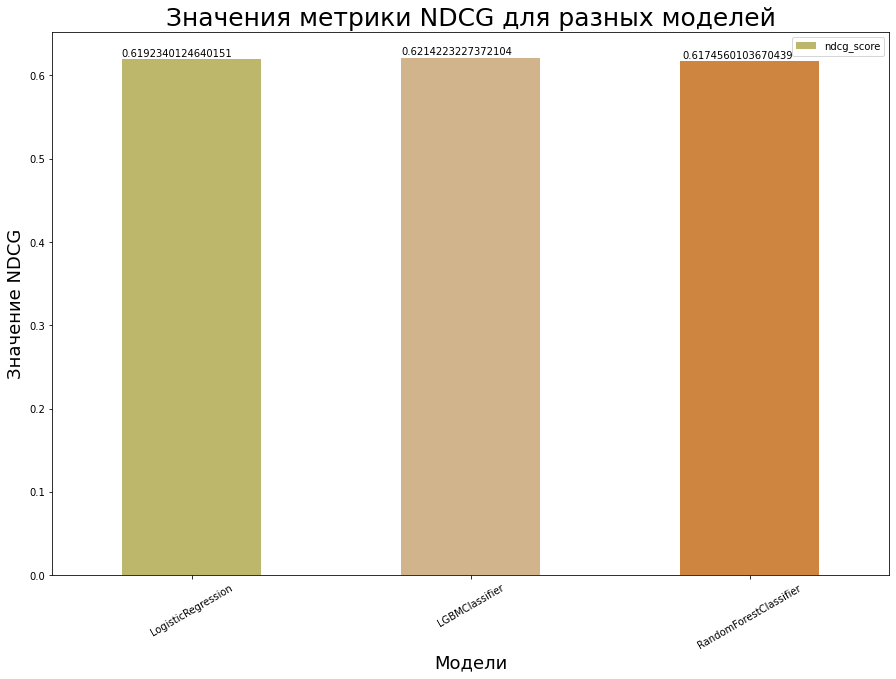

In [ ]:
my_colors = ['darkkhaki', 'tan', 'peru']

fig = plt.figure(figsize=(15,10))

ax = df_models.iloc[0].plot(kind='bar', rot=30, legend='reverse', color=my_colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
plt.title(label='Значения метрики NDCG для разных моделей', fontsize=25)    
plt.ylabel("Значение NDCG", fontsize=18)
plt.xlabel("Модели", fontsize=18)

plt.show()

Модель LGBMClassifier показала лучший результат - 0,6214, проверим её на адекватность.

## Проверка модели на адекватность

Проверим модель на адекватность выдаваемых результатов с помощью Dummy модели

In [ ]:
dummy_model = DummyClassifier()
dummy_model.fit(X_train, Y_train)

# Предсказания на тестовых данных
y_pred = dummy_model.predict(X_test) # np array
y_pred_multi = nparray_to_multiclass_multioutput(y_pred) # multiclass-multioutput

# Считаем метрику 
model_score = ndcg_score(y_test_multi, y_pred_multi)
print(f'Метрика ndcg у модели:', model_score)

Метрика ndcg у модели: 0.5891447462075795


Наша метрика выше ndcg дамми модели

# Предсказания на тестовых данных


In [ ]:
# получаем размерность векторов из модели word2vec
w2v_vector_size = w2v_trained_model.vector_size

# преобразуем каждое предложение в вектор с помощью модели word2vec
X_test_vectors_to_pred = []
for sentence in X_test_to_pred:
    # создаем пустой вектор
    sentence_vector = np.zeros(w2v_vector_size)
    # суммируем векторы слов в предложении
    for word in sentence:
        try:
            sentence_vector += w2v_trained_model[word]
        except KeyError:
            print(word, 'not in vocabulary')
    # добавляем полученный вектор в список векторов
    X_test_vectors_to_pred.append(sentence_vector)

In [ ]:
test_predictions = RF_model.predict(X_test_vectors_to_pred)
test_predictions

array([4, 4, 3, ..., 4, 4, 3])

In [ ]:
df_test['comment_score'] = test_predictions

In [ ]:
df_test.head(10)

,Unnamed: 0,text,comment_text,comment_score,comment_clear_list,comment_clear
0,0,"iOS 8.0.1 released, broken on iPhone 6 models,...",I&#x27;m still waiting for them to stabilize w...,4,"['waiting', 'stabilize', 'wifi', 'ipad', 'sith...",waiting stabilize wifi ipad sith io quality st...
1,1,"iOS 8.0.1 released, broken on iPhone 6 models,...","For those who upgraded, no need to do a restor...",4,"['upgraded', 'need', 'restore', 'option', 'cli...",upgraded need restore option click quot update...
2,2,"iOS 8.0.1 released, broken on iPhone 6 models,...",Upgraded shortly after it was released and suf...,3,"['upgraded', 'shortly', 'released', 'suffered'...",upgraded shortly released suffered consequence...
3,3,"iOS 8.0.1 released, broken on iPhone 6 models,...",I think they were under a lot of pressure on t...,4,"['think', 'lot', 'pressure', 'healthkit', 'big...",think lot pressure healthkit big flagship io f...
4,4,"iOS 8.0.1 released, broken on iPhone 6 models,...",Fix for those who already updated: http:&#x2F...,4,"['fix', 'updated', 'url']",fix updated url
5,5,Ask HN: How do US HNers get their health insur...,Get it from your employer. It&#x27;s better an...,3,"['employer', 'better', 'cheaper', 'market', 'a...",employer better cheaper market allowed supplem...
6,6,Ask HN: How do US HNers get their health insur...,As someone who moved from the UK to US under a...,1,"['moved', 'uk', 'u', 'identical', 'condition',...",moved uk u identical condition let job offer h...
7,7,Ask HN: How do US HNers get their health insur...,"I went to http:&#x2F;&#x2F;healthcare.gov, fil...",2,"['went', 'url', 'filled', 'online', 'form', 'p...",went url filled online form picked plan like a...
8,8,Ask HN: How do US HNers get their health insur...,"Full time employed, health insurance through m...",4,"['time', 'employed', 'health', 'insurance', 'e...",time employed health insurance employer group ...
9,9,Ask HN: How do US HNers get their health insur...,Your options depend on where you live.I signed...,1,"['option', 'depend', 'live', 'signed', 'covere...",option depend live signed covered california s...


In [ ]:
df_test.to_json('ranking_test_2.jsonl', orient='records', lines=True)

In [ ]:
path = '/content/drive/MyDrive/ranking_test_2.jsonl'
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
df_test.to_json(path, orient='records', lines=True)

In [ ]:
path = '/content/drive/MyDrive/ranking_test_2.csv'
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
df_test.to_csv(path, index=False)

# Промежуточные итоги

После загрузки данных мы взяли срез в 15000 строк и провели векторизацию, используя Word2Vec.

Подбирая гиперпараметры вручную, мы обучили 3 модели:
1. Logistic Regression 
2. RandomForest Classifier
3. LightGBM Classifier

Проверяя метрику на валидационной выборке, мы выяснили, что лучшие результаты показывает алгоритм LightGBM Classifier. 

Модель прошла проверку на адекватность.

Мы сделали предсказания на тестовой выборке, сохранили результаты в формате csv для дальнейшего анализа и в формате jsonl.